## Data Preparation

In [1]:
from google.colab import drive
drive.mount('/content/drive/') 
import random
import time
import pandas as pd
import ast 
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

Mounted at /content/drive/


In [2]:
data = pd.read_csv('/content/drive/My Drive/Root/Ressources/tunisia.csv')
data.head(2)

id  ...                                      thumbnail_url
0  poi:12785108  ...  https://media-cdn.sygictraveldata.com/media/po...
1  poi:34628663  ...  https://media-cdn.sygictraveldata.com/media/po...

[2 rows x 24 columns]

In [3]:
def clean_features(data):
  lst = ['id', 'location', 'name', 'name_suffix', 'categories', 'tag_keys']
  return data[lst]

def clean_location(data):
    df3 = data.copy()
    lat = []
    lng = []
    for index, row in df3.iterrows():
      d = ast.literal_eval(row['location'])
      lat.append(d['lat'])
      lng.append(d['lng'])

    #print(len(lat),len(lng))
    df3['lat'] = lat
    df3['lng'] = lng
    df3.drop('location',axis = 1, inplace=True)
    return df3

def find_Tunis_pois(df):
  regions = ['Ben Arous', 'Aryanah', 'Carthage', 'Twns', 'Tunis', 'Manouba', 
           'Medina of Tunis', 'La Goulette', 'Hy alkhdra Az Zuhoor']
  res = []
  geo = df.copy()
  for index,row in geo.iterrows():
    current = row['name_suffix'].split(',')
    yes = False
    for r in regions:
      if r in current:
        yes = True
        break
    
    if yes:
      name = row['name']
      suffix = row['name_suffix']
      lat = row['lat']
      lng = row['lng']
      index = row['id']
      tags = row['categories'] +', '+row['tag_keys']
      res.append({'id':index,'name':name,'suffix':suffix,'lat':lat,'lng':lng,'tags':tags})
  vis = pd.DataFrame(res)
  return vis

def preprocessing(data):
  df = clean_features(data)
  df = clean_location(df)
  df = find_Tunis_pois(df)
  df.drop_duplicates(subset="id",inplace=True)
  df.set_index('id',inplace=True)
  return df

df = preprocessing(data)
df.head()

name  ...          tags
id                                                           ...              
poi:12785108                                           UBCI  ...  [], ['Bank']
poi:24585120  BIAT (Banque Internationale arabe de Tunisie)  ...  [], ['Bank']
poi:12781501                                    Bnk alaskan  ...  [], ['Bank']
poi:12781484                       ATB (Arab Tunisian Bank)  ...  [], ['Bank']
poi:35965864                          Albnk altwnsy lltdamn  ...  [], ['Bank']

[5 rows x 5 columns]

## Visualization

In [19]:
import folium

def initialize_map(location=[]):
  if len(location)==0:
    location = [36.853685 , 10.323380 ]
  if len(location)==2:
    map = folium.Map(location=location, zoom_start=10,tiles='Stamen Terrain')
  return map

def show_pois_wrapped(map,data,color): #take all data and visualize it.
  locations = data[['lat', 'lng']]
  locationlist = locations.values.tolist()
  for point in range(0,len(locationlist)):
      folium.Marker(locationlist[point], icon=folium.Icon(color=color),popup=data.iloc[point,0]).add_to(map)
  return map

map = initialize_map()
show_pois_wrapped(map,df.iloc[0:100],'blue')

In [7]:
sample = random.sample(list(df.index),k=10)

In [21]:
def show_pois(map,data,indexes,color):
  try:
    data = data.loc[indexes]
    return show_pois_wrapped(map,data,color)
  except Exception as e:
    print('ERROR: ',e)

map = show_pois(map,df,sample,'blue')
map

In [29]:
sample1 = random.sample(list(df.index),k=10)
sample2 = random.sample(list(df.index),k=10)
def show_stream_pois(map, data, samples):
  color_list=['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray','darkblue']
  colors = random.sample(color_list,len(samples))
  for i in range(len(samples)):
    map = show_pois(map,data,samples[i],colors[i])

  return map

map = initialize_map()
show_stream_pois(map, df,[sample1,sample2])

In [31]:
random.seed(42)
poi1 = df.index[0]
poi2 = df.index[100]
poi1,poi2

('poi:12785108', 'poi:35986580')

In [32]:
def haversine_distance(lat1, lon1, lat2, lon2):  
   r = 6371  
   phi1 = np.radians(lat1)  
   phi2 = np.radians(lat2)  
   delta_phi = np.radians(lat2 - lat1)  
   delta_lambda = np.radians(lon2 - lon1)  
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2  
   res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))  
   return np.round(res, 2)

def geo_distance(data,poi1,poi2):
  poi1 = data.loc[poi1]
  poi2 = data.loc[poi2]
  return haversine_distance(poi1['lat'],poi1['lng'],poi2['lat'],poi2['lng'])

geo_distance(df,poi1,poi2)

11.54

In [33]:
import math
def generateRandomPoints(center, radius, count):
  points = []
  for i in range(count):
    points.append(generateRandomPoint(center,radius))
  return points

def generateRandomPoint(center,radius):
  x0 = center['lng'] #lng
  y0 = center['lat'] #lat
  rd = radius / 111300
  u = random.random()
  v = random.random()

  w = rd * math.sqrt(u)
  t = 2 * np.pi * v
  x = w * np.cos(t)
  y = w * np.sin(t)

  xp = x / np.cos(y0)

  return {'lat': y+y0, 'lng': xp+x0}

source = df.loc[df.index[0]]
randomGeoPoints = generateRandomPoints(source, 100, 1)
randomGeoPoints

[{'lat': 36.74766643925295, 'lng': 10.310523778474726}]

In [70]:
def generate_home_work_random(df,number,min,max,seed=None): #require deconstructing more...
  random.seed(seed)
  indexes = list(df.index)
  result = []
  try:
    while number > 0:
      home = random.choice(indexes)
      home_loc = generateRandomPoints(df.loc[home][['lat','lng']], 100, 1)[0] 
      work = random.choice(list(df.index))
      work_loc = df.loc[work]
      distance = haversine_distance(home_loc['lat'], home_loc['lng'], work_loc['lat'], work_loc['lng'])
      if min <= distance <= max:
        result.append({'home_id':home,
                       'home_loc':home_loc,
                       'work_id':work,
                       'work_loc':dict(df.loc[work][['lat','lng']]),
                       'distance':distance})
        number -= 1
    return pd.DataFrame(result)
  except Exception as e:
    print('Error ',e)
    return 

begin = time.time()
result = generate_home_work_random(df,1000,0.1,30,42)
end = time.time() - begin
result.head()

home_id  ... distance
0  poi:12629424  ...     4.90
1  poi:25471547  ...    11.33
2   poi:8723735  ...     0.31
3   poi:5451551  ...    20.28
4   poi:9866439  ...     8.88

[5 rows x 5 columns]

In [71]:
def initialize_map(location=[]):
  if len(location)==0:
    location = [36.853685 , 10.323380 ]
  if len(location)==2:
    map = folium.Map(location=location, zoom_start=10,tiles='Stamen Terrain')
  return map

def show_pois_wrapped(map,data,color): #take all data and visualize it.
  locations = data[['lat', 'lng']]
  locationlist = locations.values.tolist()
  for point in range(0,len(locationlist)):
      folium.Marker(locationlist[point], icon=folium.Icon(color=color),popup=str(data.iloc[point,0])).add_to(map)
  return map

def visualize_result(result):
  map = initialize_map()
  home_loc = result.loc[:,['home_loc','distance']]
  work_loc = result.loc[:,['work_loc','distance']]
  home_loc .rename(columns={"home_loc": "location"})
  work_loc .rename(columns={"work_loc": "location"})

  lat = []
  lng = []
  for _,row in home_loc.iterrows():
    lat.append(row['home_loc']['lat'])
    lng.append(row['home_loc']['lng'])

  home_loc['lat'] = lat
  home_loc['lng'] = lng

  home_loc.drop('home_loc',axis = 1, inplace=True)

  lat = []
  lng = []
  for _,row in work_loc.iterrows():
    lat.append(row['work_loc']['lat'])
    lng.append(row['work_loc']['lng'])

  work_loc['lat'] = lat
  work_loc['lng'] = lng

  work_loc.drop('work_loc',axis = 1, inplace=True)

  map = show_pois_wrapped(map,home_loc,'green')
  map = show_pois_wrapped(map,work_loc,'red')

  return map

visualize_result(result)

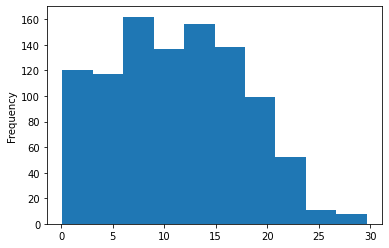

In [72]:
result.distance.plot(kind='hist')

In [ ]:
#find a good api for sql generation
#make one last optimization for running performance
#next time try dash, plotly

In [ ]:
!pip install keplergl

In [ ]:
from keplergl import KeplerGl
map1=KeplerGl(height=500)
map1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(height=500)

In [ ]:
map1.add_data(data=df,name='yeeey')